In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pred = np.load('NionRelated/GPrun_1000iter_0_prediction.npy')
abr = np.load('NionRelated/GPrun_1000iter_0_abr_coeff.npy')
best_seen = np.argmax(pred)
print(np.abs(abr[best_seen,:] - np.array([0.5] * 12)))
print(np.abs(abr[0,:] - np.array([0.5] * 12)))

[0.00406461 0.00813799 0.00723209 0.0278691  0.00841699 0.00277532
 0.00564077 0.03101505 0.02854815 0.06288952 0.00175093 0.04333777]
[0.00577017 0.02591734 0.00615912 0.03745571 0.03188779 0.03287222
 0.00108163 0.0174661  0.01704449 0.04515394 0.0245492  0.00242561]


In [7]:
print(abr[best_seen])

[0.49593539 0.50813799 0.50723209 0.4721309  0.50841699 0.49722468
 0.50564077 0.46898495 0.47145185 0.43711048 0.50175093 0.45666223]


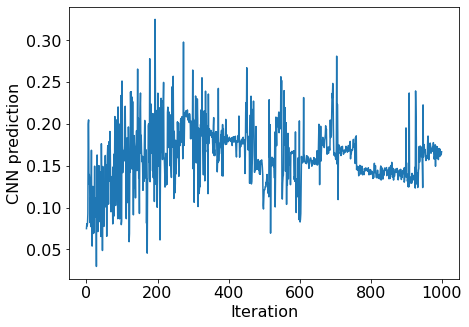

In [3]:
fig, ax = plt.subplots(1,1, figsize = [7,5])
p = ax.plot(1 - pred)
ax.set_xlabel('Iteration',fontsize = 16)
ax.set_ylabel('CNN prediction', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

In [4]:
abr_list = ["C10", "C12.x", "C12.y", "C21.x", "C21.y", "C23.x", "C23.y", "C30", 
"C32.x", "C32.y", "C34.x", "C34.y"]

abr_lim = [2e-6, 2e-6, 2e-6, 3e-5, 3e-5, 3e-5, 3e-5, 4e-4, 3e-4, 3e-4, 3e-4, 3e-4]

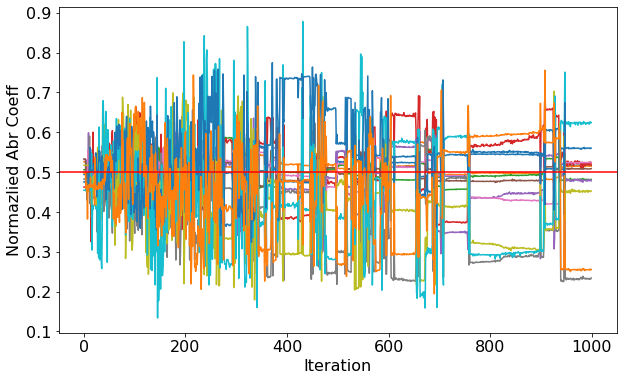

In [5]:
fig, ax = plt.subplots(1,1, figsize = [10,6])
for i in range(abr.shape[1]):
    p = ax.plot(abr[:,i])
ax.set_xlabel('Iteration',fontsize = 16)
ax.set_ylabel('Normazlied Abr Coeff', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.axhline(y=0.5, c='r')